## Outline

1. Introduce dataset
2. Data Processing - Test-train split, encoding, visualisation
3. Basic RNN - testing inference
4. Evaluation and Training
5. LSTM
6. GRU

In [1]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
from IPython.display import clear_output

In [5]:
X=[]
y=[]
data=[]
language=set()
with open('name2lang.txt','r') as f:
  for line in f:
    line=line.split(',')
    name=line[0].strip()
    lang=line[1].strip()
    language.add(lang)
    X.append(name)
    y.append(lang)
    data.append((name,lang))

n_language=len(language)


In [6]:
language=list(language)

In [7]:
print(language)

['Russian', 'Czech', 'Korean', 'English', 'Spanish', 'Japanese', 'Dutch', 'Scottish', 'Polish', 'Vietnamese', 'German', 'Portuguese', 'Italian', 'Chinese', 'French', 'Arabic', 'Greek', 'Irish']


In [8]:
print(data[:10])

[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


## Train Test Split

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)


In [10]:
print(len(X_train),len(X_test))

16040 4010


## Encoding names and language

In [11]:
all_letters=string.ascii_letters+' .,;'
n_letters=len(all_letters)

In [12]:
def name_rep(name):
  rep=torch.zeros(len(name),1,n_letters)
  for index,letter in enumerate(name):
    pos=all_letters.find(letter)
    rep[index][0][pos]=1
  return rep

In [13]:
def lang_rep(lang):
  return torch.tensor([language.index(lang)],dtype=torch.long)

In [14]:
name_rep('Karveandhan').shape

torch.Size([11, 1, 56])

In [15]:
lang_rep('English')

tensor([3])

## Basic Visualization

In [16]:
count={}
for l in language:
  count[l]=0
for d in data:
  count[d[1]]+=1

In [17]:
count

{'Russian': 9384,
 'Czech': 519,
 'Korean': 94,
 'English': 3668,
 'Spanish': 298,
 'Japanese': 991,
 'Dutch': 297,
 'Scottish': 100,
 'Polish': 139,
 'Vietnamese': 73,
 'German': 724,
 'Portuguese': 74,
 'Italian': 709,
 'Chinese': 268,
 'French': 277,
 'Arabic': 2000,
 'Greek': 203,
 'Irish': 232}

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


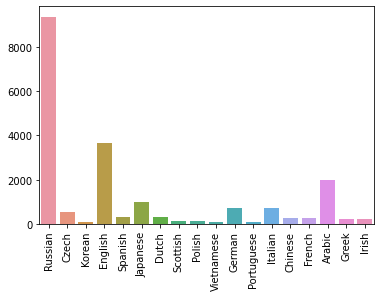

In [18]:
plt_=sns.barplot(list(count.keys()),list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(),rotation=90)
plt.show()

## Basic network and testing inference

In [19]:
#Predicting Russian all the time
count['Russian']/sum(count.values())

0.4680299251870324

In [20]:
class RNN_net(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(RNN_net,self).__init__()
    self.hidden_size=hidden_size
    self.i2h=nn.Linear(input_size+hidden_size,hidden_size)
    self.i2o=nn.Linear(input_size+hidden_size,output_size)
    self.softmax=nn.LogSoftmax(dim=1)

  def forward(self,input_,hidden):
    combined=torch.cat((input_,hidden),1)
    hidden=self.i2h(combined)
    output=self.i2o(combined)
    output=self.softmax(output)
    return output,hidden

  def init_hidden(self):
    return torch.zeros(1,self.hidden_size)

In [21]:
n_hidden=128
net=RNN_net(n_letters,n_hidden,n_language)


In [22]:
def infer(net,name):
  net.eval()
  name_ohe=name_rep(name)
  hidden=net.init_hidden()

  for i in range(name_ohe.size()[0]):
    output,hidden=net(name_ohe[i],hidden)

  return output

In [23]:
output=infer(net,'Adam')
index=torch.argmax(output)
print(output,index)

tensor([[-3.0058, -2.7926, -2.8905, -2.7316, -2.8243, -2.8547, -2.8152, -3.0654,
         -2.9865, -2.9395, -2.9190, -2.9282, -2.9510, -2.9491, -2.8440, -2.9161,
         -2.8493, -2.8235]], grad_fn=<LogSoftmaxBackward0>) tensor(3)


## Evaluate model

In [24]:
def dataloader(npoints,X_,y_):
  to_ret=[]
  for i in range(npoints):
    index_=np.random.randint(len(X_))
    name,lang=X_[index_],y_[index_]
    to_ret.append((name,lang,name_rep(name),lang_rep(lang)))

  return to_ret

In [25]:
def eval(net,n_points,k,X_,y_):
  data_=dataloader(n_points,X_,y_)
  correct=0

  for name,language,name_ohe,lang_rep in data_:
    output=infer(net,name)
    val,indices=output.topk(k)

    if lang_rep in indices:
      correct+=1

  accuracy=correct/n_points
  return accuracy

In [26]:
eval(net,1000,1,X_test,y_test)

0.066

## Training

### Basic Setup

In [27]:
def train(net,opt,criterion,n_points):
  opt.zero_grad()
  total_loss=0
  data_=dataloader(n_points,X_train,y_train)
  for name, language, name_ohe, lang_rep in data_:
    hidden=net.init_hidden()
    for i in range(name_ohe.size()[0]):
      output,hidden=net(name_ohe[i],hidden)

    loss=criterion(output,lang_rep)
    loss.backward(retain_graph=True)

    total_loss+=loss
  
  opt.step()

  return total_loss/n_points

In [28]:
criterion=nn.NLLLoss()
opt=optim.SGD(net.parameters(),lr=0.01,momentum=0.9)


In [29]:
%%time

train(net,opt,criterion,200)

CPU times: user 172 ms, sys: 18.2 ms, total: 190 ms
Wall time: 262 ms


tensor(2.8943, grad_fn=<DivBackward0>)

In [30]:
eval(net,1000,1,X_test,y_test)

0.484

## Full Training setup

In [31]:
def train_setup(net,lr=0.01,n_batches=100,batch_size=10,momentum=0.9,display_freq=5):
  criterion=nn.NLLLoss()
  opt=optim.SGD(net.parameters(),lr=lr,momentum=momentum)
  
  loss_arr=np.zeros(n_batches+1)
  
  for i in range(n_batches):
    loss_arr[i+1]=(loss_arr[i]*i+train(net,opt,criterion,batch_size))/(i+1)

    if i%display_freq ==display_freq-1:
      clear_output(wait=True)

      print('Iteration ',i,'Top-1:',eval(net,len(X_test),1,X_test,y_test),'Top-2:',eval(net,len(X_test),2,X_test,y_test))
      plt.figure()
      plt.plot(loss_arr[1:i],'-*')
      plt.xlabel('Iteration')
      plt.ylabel('Loss')
      plt.show()
      print('\n\n')

Iteration  99 Top-1: 0.6518703241895262 Top-2: 0.7815461346633417


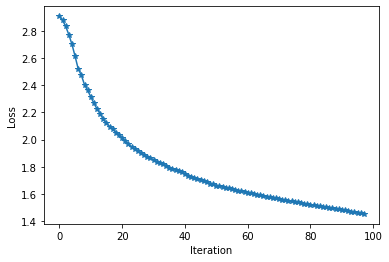

In [32]:
n_hidden=128
net=RNN_net(n_letters,n_hidden,n_language)
train_setup(net,lr=0.0005,n_batches=100,batch_size=256)

## LSTM cell

In [39]:
class LSTM_net(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(LSTM_net,self).__init__()
    self.hidden_size=hidden_size
    self.lstm_cell=nn.LSTM(input_size,hidden_size)
    self.h2o=nn.Linear(hidden_size,output_size)
    self.softmax=nn.LogSoftmax(dim=2)
  
  def forward(self,input_,hidden):
    out,hidden=self.lstm_cell(input_.view(1,1,-1),hidden)
    output=self.h2o(hidden[0])
    output=self.softmax(output)
    return output.view(1,-1),hidden

  def init_hidden(self):
    return (torch.zeros(1,1,self.hidden_size),torch.zeros(1,1,self.hidden_size))


Iteration  99 Top-1: 0.5341645885286783 Top-2: 0.6785536159600998


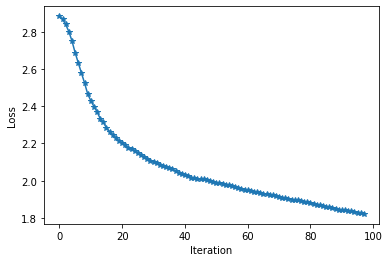

In [40]:
n_hidden=128
net=LSTM_net(n_letters,n_hidden,n_language)
train_setup(net,lr=0.0005,n_batches=100,batch_size=256)

In [41]:
class GRU_net(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(GRU_net,self).__init__()
    self.hidden_size=hidden_size
    self.gru_cell=nn.GRU(input_size,hidden_size)
    self.h2o=nn.Linear(hidden_size,output_size)
    self.softmax=nn.LogSoftmax(dim=2)

  def forward(self,input_,hidden):
    out,hidden=self.gru_cell(input_.view(1,1,-1),hidden)
    output=self.h2o(hidden)
    output=self.softmax(output)
    return output.view(1,-1),hidden

  def init_hidden(self):
    return torch.zeros(1,1,self.hidden_size)

Iteration  99 Top-1: 0.6057356608478803 Top-2: 0.7433915211970075


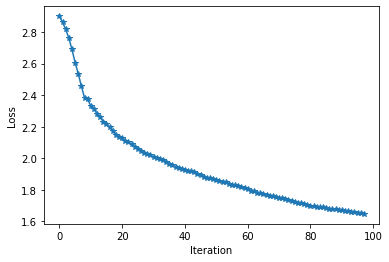

In [42]:
n_hidden=128
net=GRU_net(n_letters,n_hidden,n_language)
train_setup(net,lr=0.0005,n_batches=100,batch_size=256)